# Draw the concept graph
Open rviz and use the rviz config `bagplay_concept.rviz`. You can launch ros core and rviz from the `robotparam_and_rviz.launch`

The code loads a recorded rosbag, and pass the topics into registered callback functions. You can modify the following callbacks to alter the style of the visulization. What's more, you can choose a good period for the replay.

In [1]:
import rospy # for `Duration`
import rosbag
from semantic_front_end_filter.common import RosbagPlayer

In [2]:
# Import the modules for the model
from semantic_front_end_filter.adabins.pointcloudUtils import RaycastCamera
from semantic_front_end_filter.adabins.models import UnetAdaptiveBins
from semantic_front_end_filter.adabins.model_io import load_checkpoint, load_param_from_path

import torch 
from torch import nn
import numpy as np
from semantic_front_end_filter.Labelling.messages.imageMessage import Camera, getImageId, rgb_msg_to_image
from semantic_front_end_filter.Labelling.messages.pointcloudMessage import rospcmsg_to_pcarray, ros_pc_msg2
from semantic_front_end_filter.Labelling.messages.messageToVectors import msg_to_body_ang_vel, msg_to_body_lin_vel, msg_to_rotmat, msg_to_command, \
    msg_to_pose, msg_to_joint_positions, msg_to_joint_velocities, msg_to_joint_torques, msg_to_grav_vec

In [5]:
# rosbagpath = "/Data/Italy_0820/18-20-34-01/Reconstruct_2022-07-18-20-34-01_0.bag"
# rosbagpath = "/Data/hongeberg/mission_data/Reconstruct/Reconstruct_2022-08-13-21-01-10_0.bag" # highgrass back

rosbagpath = "/Data/Italy_0820/19-18-16-39/Reconstruct_2022-07-19-18-16-39_0.bag" # Perugia high grass # good: 437

# rosbagpath = "/Data/Italy_0820/Reconstruct_2022-07-21-10-47-29_0.bag" # Perugia high grass # good: 437
player = RosbagPlayer(rosbagpath)

In [6]:
rospy.init_node('draw_elev_map', anonymous=False)
player.add_publisher_of_topic("/alphasense_driver_ros/imu")
player.add_publisher_of_topic("/tf", queue_size=1000)
player.add_publisher_of_topic("/tf_static")
player.add_publisher_of_topic("/clock")
player.add_publisher_of_topic("/twist_mux/twist")
player.add_publisher_of_topic("/alphasense_driver_ros/cam4/debayered")
player.play(end_time = player.bag.get_start_time()+10)

In [14]:
player.play()

In [ ]:
torch.cuda.empty_cache()# this is useless

In [7]:
# modelname = "2022-09-03-09-24-05_final"
modelname = "2022-09-04-19-38-09_bn"
model_path = f"../checkpoints/{modelname}/UnetAdaptiveBins_best.pt"
image_topic = "/alphasense_driver_ros/cam4/debayered"
pc_topic = "/bpearl_rear/point_cloud"
TF_BASE = "base"
TF_MAP = "map"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
raycastCamera = RaycastCamera(device=device) # WARN: This raycastcamera is hard coded with `tf_base_to_sensor`, however, it seems to be constant


## Initialize model
model_cfg = load_param_from_path(model_path)
model_cfg["input_channel"] = 4
model = UnetAdaptiveBins.build(**model_cfg)

model = load_checkpoint(model_path, model)[0]
model.to(device)

Loading base model ()...Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.


UnetAdaptiveBins(
  (encoder): Encoder(
    (original_model): GenEfficientNet(
      (conv_stem): Conv2d(4, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SiLU(inplace=True)
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            )
            (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(24, eps=0.0

In [53]:
from sensor_msgs import point_cloud2
from sensor_msgs.msg import PointCloud2, PointField
from std_msgs.msg import Header
from sensor_msgs.msg import Image
from visualization_msgs.msg import Marker
from geometry_msgs.msg import Point
import struct
from cv_bridge import CvBridge
image_cv_bridge = CvBridge()
from tf.transformations import euler_from_quaternion


def buildPoint(x, y, z, r, g, b, a=None):
    if(np.array([r, g, b]).max() < 1.01):
        r = int(r * 255.0)
        g = int(g * 255.0)
        b = int(b * 255.0)
        a = 255 if a is None else int(a * 255.0)
    else:
        r = int(r)
        g = int(g)
        b = int(b)
        a = 255 if a is None else int(a)
    rgb = struct.unpack('I', struct.pack('BBBB', b, g, r, a))[0]
    return [x, y, z, rgb]
rospy.init_node('draw_elev_map', anonymous=False)
pred_pc_pub1 = rospy.Publisher("pc/pred_pc/pub1", PointCloud2, queue_size=1)
raw_pc_pub1 = rospy.Publisher("pc/raw_pc/pub1", PointCloud2, queue_size=1)
pred_pc_pub2 = rospy.Publisher("pc/pred_pc/pub2", PointCloud2, queue_size=1)
raw_pc_pub2 = rospy.Publisher("pc/raw_pc/pub2", PointCloud2, queue_size=1)
image_pub = rospy.Publisher("cam_image", Image, queue_size=1)
marker_pub = rospy.Publisher("markers/pred_raw_connection", Marker, queue_size=1)
marker_pub2 = rospy.Publisher("markers/cam_raw_connection", Marker, queue_size=1)

## Configs of the line_list style
line_list_msg1 = Marker(
    header = Header(frame_id = "map"),
    ns = "raw2pred",
    action = 0,
    type = 5,
    id = 42,
    color = type(Marker().color)(
            r = 0.5, g=0.2,b = 0.2,a = 0.2
        ),
    scale = type(Marker().scale)(
        x=0.01
    ),
    points = []
)
# line_list_msg.type = 5

line_list_msg2 = Marker(
    header = Header(frame_id = "map"),
    ns = "cam2raw",
    action = 0,
    type = 5,
    id = 1,
    color = type(Marker().color)(
            r = 0.5, g=0.2, b = 0.2,a = 0.2
        ),
    scale = type(Marker().scale)(
        x=0.001
    ),
    points = []
)


player._shared_var.update(dict(
    pcbuffer=[],
    modeliobuffer = {"pose":None, "cam_pose":None,
                     "model_in": None, "model_out": None} 
))

def pred_and_checkerr(image, pc, pose,v):
    """
    Make the prediction based on image, pointcloud and robot current pose
    arg pose: x,y,z,rx,ry,rz,rw
    """
    image = torch.Tensor(image).to(device)
    points = torch.Tensor(pc).to(device)

    # highlight the near high grass
#     highlight_mask = (points[:,2]>pose[2]-0.15)\
#             & (torch.sum((points[:,:2]-torch.tensor(pose[:2]).to(device))**2, axis = 1)<3**2)
    
    # highlight close points
#     highlight_mask = (torch.sum((points[:,:2]-torch.tensor(pose[:2]).to(device))**2, axis = 1)<10**2)

    raycastCamera.camera.update_pose_from_base_pose(pose)
    camera_heading = torch.Tensor(raycastCamera.camera.pose[1][:3, 2]).cuda()
    camera_heading[2] = 0
    camera_heading/= (camera_heading**2).sum().sqrt()
    point_dir = points - torch.Tensor(raycastCamera.camera.pose[0]).cuda()
    point_dir[:,2] = 0
    point_dir = point_dir/torch.sqrt(torch.sum(point_dir**2,axis = 1))[...,None]
    highlight_mask = ((point_dir@camera_heading) > 0.98) \
            & (torch.sum((points[:,:2]-torch.tensor(pose[:2]).to(device))**2, axis = 1)<2**2)

    points_highlight = points[highlight_mask] 
#     points = points[~highlight_mask] # this line is used for pc from cam point of view
    
    # get pc image
    pc_img = torch.zeros_like(image[:1, ...],dtype = torch.float32).to(device)
    pc_img,visible,proj_point = raycastCamera.project_cloud_to_depth(
                    pose, points, pc_img, return_detail=True)
    pc_img_highlight = torch.zeros_like(image[:1, ...],dtype = torch.float32).to(device)
    pc_img_highlight = raycastCamera.project_cloud_to_depth(
                    pose, points_highlight, pc_img_highlight)
    # filter the points to the only visble ones
    points = points[visible] # TODO: Decide whether should be filter the raw points
    # get prediction
    model_in = torch.cat([image/255., pc_img.clone()],axis=0)
    model_in = model_in[None, ...]
    for i, (m, s) in enumerate(zip([0.387, 0.394, 0.404, 0.120], [0.322, 0.32, 0.30,  1.17])):
        model_in[0, i, ...] = (model_in[0, i, ...] - m)/s
    model_out = model(model_in).detach()
    model_out = nn.functional.interpolate(model_out, pc_img.shape[-2:], mode="nearest")
    pred = model_out[0][0]
#     pred = nn.functional.interpolate(pred[None,None,...], pc_img.shape[-2:], mode="nearest")[0,0]
    
    v["modeliobuffer"].update({
        "pose": pose,
        "model_in": model_in.cpu(),
        "model_out": model_out.detach().cpu()
    })

    pred [(pc_img[0]==0)] = np.nan
    pred = pred.T

    # get elevation from prediction
    highlight_mask = abs(pc_img_highlight.T.reshape(-1))>1e-9
    
    pred_pts = raycastCamera.project_depth_to_cloud(pose, pred)
    pred_pts_highlight = pred_pts[highlight_mask]
    pred_pts = pred_pts[~torch.isnan(pred_pts[:,0])]
    # pred_pts = pred_pts[pred_pts[:,2]<pose[2]] # TODO: Decide whether this hieight mask is necessary
    pred_points = pred_pts.detach().cpu().numpy()
    pred_highlight_nanmask = torch.isnan(pred_pts_highlight[:,0])
    pred_points_highlight = pred_pts_highlight[~pred_highlight_nanmask].detach().cpu().numpy()
    
    
## Deprectaed way of getting raw points and colors
#     raw_points = points.cpu().numpy().astype(pred_points.dtype) # float_64
#     proj_point = proj_point.cpu().numpy()
#     colors_raw = np.moveaxis((image.cpu().numpy())[:3,proj_point[:,1], proj_point[:,0]], 0, 1)

    # Use reprojected raw_pts, otherwise the position of raw pc and pred pc are not aligned
    pc_img[abs(pc_img)<1e-9] = np.nan
    raw_pts = raycastCamera.project_depth_to_cloud(pose, pc_img.T)
    raw_pts_highlight = raw_pts[highlight_mask]
    raw_rgb = torch.vstack([(image[cnl].T).reshape(-1) for cnl in range(3)]).T
    raw_rgb = (raw_rgb-raw_rgb.min())/(raw_rgb.max() - raw_rgb.min())
    raw_rgb_highlight = raw_rgb[highlight_mask]
    raw_rgb = raw_rgb[~torch.isnan(raw_pts[:,0])]
    raw_pts = raw_pts[~torch.isnan(raw_pts[:,0])]
    raw_points = raw_pts.cpu().numpy()
    raw_colors = raw_rgb.cpu().numpy()
    
    raw_highlight_nanmask = torch.isnan(raw_pts_highlight[:,0])
    raw_points_highlight = raw_pts_highlight[~raw_highlight_nanmask].cpu().numpy()
    raw_colors_highlight = raw_rgb_highlight[~raw_highlight_nanmask].cpu().numpy()
    
    ### TRICK MOVE pred_points_highlight toward ground
    highlightmask = pred_points_highlight[:,2]<raw_points_highlight[:,2]-1e-3
    pred_points_highlight = pred_points_highlight[highlightmask]
    raw_points_highlight = raw_points_highlight[highlightmask]
    Hackmask = (np.random.rand(raw_points_highlight.shape[0])<0.985)
    pred_points_highlight[Hackmask] = raw_points_highlight[Hackmask] \
                + (pred_points_highlight[Hackmask] - raw_points_highlight[Hackmask]) \
                    * (pose[2]-0.5 - raw_points_highlight[Hackmask,2:]+0.1*np.random.randn(Hackmask.sum(),1))\
                        /(pred_points_highlight[Hackmask,2:] - raw_points_highlight[Hackmask,2:])
#     ### TRICK RAW POINTS MASK
#     allmask = pred_points[:,2]<raw_points[:,2]-1e-3
#     pred_points = pred_points[allmask]
#     raw_points = raw_points[allmask]
    
    
    header = Header()
    header.frame_id = "map"
    fields = [
        PointField('x', 0, PointField.FLOAT32, 1),
        PointField('y', 4, PointField.FLOAT32, 1),
        PointField('z', 8, PointField.FLOAT32, 1),
        # PointField('rgb', 12, PointField.UINT32, 1),
        PointField('rgba', 12, PointField.UINT32, 1),
    ]
    
    color_pred_high = np.array([[255,170,0.]])/256
    color_pred_low = np.array([[80,60,0.]])/256
    colors_pred = np.ones((pred_points.shape[0],1)) * color_pred_low
#     colors_pred = np.clip(1.5*(pred_points[:, 2]-pred_points[:, 2].min())
#         /(pred_points[:, 2].max()-pred_points[:, 2].min()),0.,1.)[:,None] \
#         * (color_pred_high- color_pred_low) + color_pred_low
    cloud_pred = point_cloud2.create_cloud(header, fields,
                                [buildPoint(*p[:3], *c) for p, c in zip(pred_points, colors_pred)])
    cloud_pred_highlight = point_cloud2.create_cloud(header, fields,
                                [buildPoint(*p[:3], 0.,0.,0.) for p in pred_points_highlight])
    pred_pc_pub1.publish(cloud_pred)
    pred_pc_pub2.publish(cloud_pred_highlight)
    

    
    cloud_raw = point_cloud2.create_cloud(header, fields,
                                [buildPoint(*p[:3], *c) for p, c in zip(raw_points, raw_colors)])
    cloud_raw_highlight = point_cloud2.create_cloud(header, fields,
                                [buildPoint(*p[:3], *c) for p, c in zip(raw_points_highlight, raw_colors_highlight)])
    
    raw_pc_pub1.publish(cloud_raw)
    raw_pc_pub2.publish(cloud_raw_highlight)
    
    line_list_msg1.points = [ p
        for pp, rp in zip(pred_points_highlight[::3], raw_points_highlight[::3])
        for p in [Point(*pp[:3]), Point(*rp[:3])]
#         for p in [Point(*raycastCamera.camera.pose[0]), Point(*pp[:3])]
    ]
#     line_list_msg.points = [ p
#         for pp, rp in zip(pred_points[::300], raw_points[::300])
# #         for p in [Point(*pp[:3]), Point(*rp[:3])]
#         for p in [Point(*raycastCamera.camera.pose[0]), Point(*rp[:3])]
#     ]
    marker_pub.publish(line_list_msg1)
    
    line_list_msg2.points = [ p
        for pp, rp in zip(pred_points_highlight[::3], raw_points_highlight[::3])
        for p in [Point(*raycastCamera.camera.pose[0]), Point(*rp[:3])]
    ]
    marker_pub2.publish(line_list_msg2)
    
    image_to_show = np.moveaxis(image.cpu().numpy(), 0, 2).astype(np.uint8)
    image_pub.publish(image_cv_bridge.cv2_to_imgmsg(image_to_show, "bgr8"))
    
#     raw_surface_pub.publish(elevmsg_cache_raw)
    


def image_cb(topic, msg, t, tf_buffer, v):
    if(not len(v["pcbuffer"])): return

    img = rgb_msg_to_image(msg, raycastCamera.camera.is_debayered, raycastCamera.camera.rb_swap, ("compressed" in topic))
    img = np.moveaxis(img, 2, 0)

    if not (tf_buffer.can_transform_core(TF_MAP, TF_BASE,  msg.header.stamp)[0]): return 
    tf = tf_buffer.lookup_transform_core(TF_MAP, TF_BASE, msg.header.stamp)
    pose = msg_to_pose(tf)  # pose in fixed ref frame (odom or map)

    pc = np.concatenate(v["pcbuffer"],axis = 0)
    pred_and_checkerr(img, pc, pose, v)
    cam_tf = tf_buffer.lookup_transform_core(TF_MAP, "cam4_sensor_frame",  msg.header.stamp)
    cam_pose = msg_to_pose(cam_tf)
    v["modeliobuffer"].update({
        "cam_pose": cam_pose
    })

    v["pcbuffer"] = v["pcbuffer"][-10:]
#     v["pcbuffer"] = []

player.register_callback(image_topic, image_cb)


def pointcloud_cb(topic, msg, t, tf_buffer, v):
    if not (tf_buffer.can_transform_core(TF_MAP, msg.header.frame_id,  msg.header.stamp)[0]): return
    tf = tf_buffer.lookup_transform_core(TF_MAP, msg.header.frame_id,  msg.header.stamp)
    pose = msg_to_pose(tf)
    pc_array = rospcmsg_to_pcarray(msg, pose)

    v["pcbuffer"].append(pc_array[:,:3])
#     v["pcbuffer"] = [pc_array[:,:3]]
    
player.register_callback(pc_topic, pointcloud_cb)


In [45]:
# player._callbacks.pop("/bpearl_rear/point_cloud")
# player._callbacks.pop("/alphasense_driver_ros/cam4/debayered")
# player._callbacks.keys()

In [54]:
# player.play(start_time= player.bag.get_start_time()+450, # the time for concept figure
#             end_time = player.bag.get_start_time()+452)
# player.play(start_time= player.bag.get_start_time()+422, # the time for system figure
#             end_time = player.bag.get_start_time()+424)
#####
# player.play(start_time= player.bag.get_start_time()+450, 
#             end_time = player.bag.get_start_time()+457)
#####
# player.play(end_time = player.bag.get_start_time()+10)
# player.play(start_time= player.bag.get_start_time()+20,  # highgrass back
#             end_time = player.bag.get_start_time()+30)

player.play(start_time= player.bag.get_start_time()+437, # Perugia high grass
            end_time = player.bag.get_start_time()+438)

In [20]:
# start = 30
start = 20
duration = 2.3

In [21]:
print(f"{start} -> {start+duration}")
player.play(start_time= player.bag.get_start_time()+start,
            end_time = player.bag.get_start_time()+start+duration)
start+=duration+0.05
# print(player._shared_var["height_range"])

20 -> 22.3


In [29]:
import pickle as pkl
with open("../tmp/systemmodel2.pkl","wb") as f:
    pkl.dump(player._shared_var["modeliobuffer"],f)

KeyError: 'modeliobuffer'

pred_dilation 1.4275672 51.681686
pcimg_dilation 0.9070593 44.936672


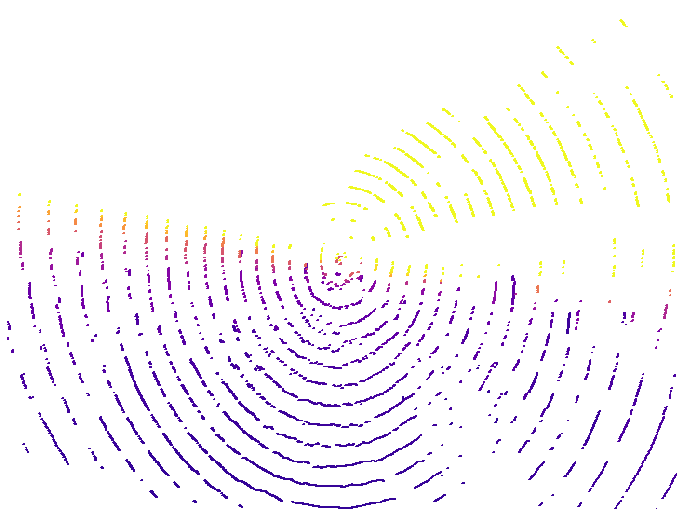

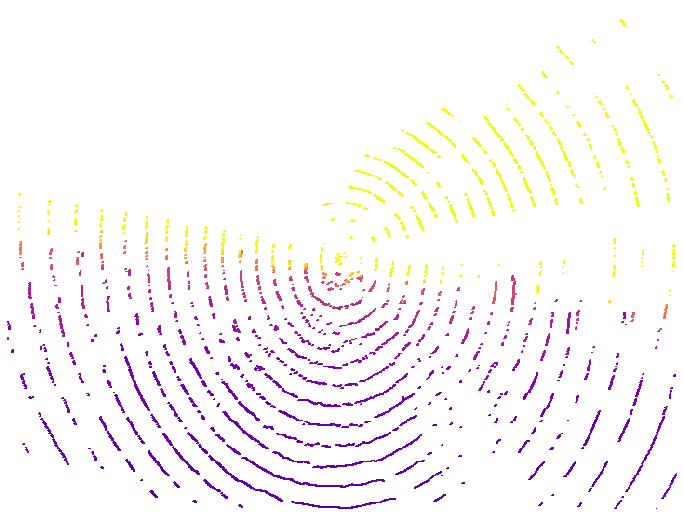

In [16]:
import matplotlib.pyplot as plt
import cv2

def maxdilation(img):
    out = np.ones_like(img) * img.min()
    out[:-1,:-1] = np.max(np.stack([out[:-1,:-1], img[1:,1:]]), axis = 0)
    out[:-1,:] = np.max(np.stack([out[:-1,:], img[1:,:]]), axis = 0)
    out[:-1,1:] = np.max(np.stack([out[:-1,1:], img[1:,:-1]]), axis = 0)
    out[:,:-1] = np.max(np.stack([out[:,:-1], img[:,1:]]), axis = 0)
    out[:,:] = img[:,:]
    out[:,1:] = np.max(np.stack([out[:,1:], img[:,:-1]]), axis = 0)
    out[1:,:-1] = np.max(np.stack([out[1:,:-1], img[:-1,1:]]), axis = 0)
    out[1:,:] = np.max(np.stack([out[1:,:], img[:-1,:]]), axis = 0)
    out[1:,1:] = np.max(np.stack([out[1:,1:], img[:-1,:-1]]), axis = 0)
    return out

pred = player._shared_var["modeliobuffer"]["model_out"][0,0].numpy()
pc_img = player._shared_var["modeliobuffer"]["model_in"][0,3].numpy()
pred[(pc_img<1e-9)] = 0

pred_dilation = maxdilation(pred)
pred_dilation[pred_dilation<1e-9] = np.nan

pcimg_dilation = maxdilation(pc_img)
pcimg_dilation[pcimg_dilation<1e-9] = np.nan

# plt.imshow(pred_dilation)
plt.figure(figsize=(12,16))
print("pred_dilation", pred_dilation[~np.isnan(pred_dilation)].min(), pred_dilation[~np.isnan(pred_dilation)].max())
print("pcimg_dilation", pcimg_dilation[~np.isnan(pcimg_dilation)].min(), pcimg_dilation[~np.isnan(pcimg_dilation)].max())
plt.imshow(pcimg_dilation, vmin = 0, vmax = 15, cmap = "plasma")
plt.axis("off")
plt.savefig("/home/chenyu/Pictures/system/system_pcimg2.png", bbox_inches='tight', pad_inches=0)
plt.figure(figsize=(12,16))
plt.imshow(pred_dilation, vmin = 0, vmax = 10, cmap = "plasma")
plt.axis("off")
plt.savefig("/home/chenyu/Pictures/system/system_predimg2.png", bbox_inches='tight', pad_inches=0)


In [ ]:
from semantic_front_end_filter.Labelling.ExtractDepthImage import DIFG
from ruamel.yaml import YAML
cfg = YAML().load(open("../semantic_front_end_filter/Labelling/data_extraction_SA.yaml", 'r'))
GroundMap_filepath = "/Data/Italy_0820/GroundMap.msgpack"
depth_img_cam = DIFG(GroundMap_filepath, cfg['calibration'], 'cam4', cfg)
depth_img_cam.DATASET_TYPE = "Italy"

In [ ]:

pose = player._shared_var["modeliobuffer"]["cam_pose"]
position = np.array(pose[:3])
euler = np.array(euler_from_quaternion(pose[3:]))
d_img, v_img = depth_img_cam.getDImage(transition=position, rotation=euler, ratation_is_matrix=False)
d_img[v_img>0.03] = np.nan
d_img[d_img > 20] = np.nan
fig = plt.figure(figsize=(12,16))
plt.imshow(d_img, vmin = 0, vmax = 10, cmap = "plasma")
plt.axis("off")
plt.savefig("/home/chenyu/Pictures/system/system_trajlabel.png", bbox_inches='tight', pad_inches=0)

# Draw the foot holds

use the rviz config file `semantic_front_end_filter_ros/configs/bagplay_footholds.rviz`

In [10]:
import rospy 
import numpy as np
from semantic_front_end_filter.Labelling.GroundfromTrajs import GFT
from visualization_msgs.msg import Marker, MarkerArray
from geometry_msgs.msg import Pose, Quaternion, Point
from std_msgs.msg import Header, Float32MultiArray, MultiArrayLayout, MultiArrayDimension


# foottrajpath = "/Data/Italy_0820/FeetTrajs.msgpack"
foottrajpath = "/Data/Italy_0820/19-18-16-39/FeetTrajs.msgpack"

gft = GFT(FeetTrajsFile = foottrajpath, InitializeGP=False)
foot_holds = {k : np.array(gft.getContactPoints(v)[0]) for k,v in gft.FeetTrajs.items()} # A dict of the contact points of each foot
# foot_holds_array = np.vstack([v[-4000:-1200] for v in foot_holds.values()])
foot_holds_array = np.vstack(list(foot_holds.values()))
# rosbagpath = "/Data/Italy_0820/Reconstruct_2022-07-18-20-34-01_0.bag"
# rospy.init_node('draw_elev_map', anonymous=False)

File is loaded successfully.
Extracting Contact points ......
Extracting Contact points ......
Extracting Contact points ......
Extracting Contact points ......


/home/chenyu/projects/kpconv/semantic_front_end_filter/semantic_front_end_filter/Labelling/GroundfromTrajs.py:175: RuntimeWarning: invalid value encountered in true_divide
  GroundArray = np.true_divide(GroundArray, CountContactArray)


Extracting Contact points ......
Extracting Contact points ......
Extracting Contact points ......
Extracting Contact points ......


In [55]:
footholds_pub = rospy.Publisher("labeling/footholds", Marker, queue_size=1)


line_list_msg = Marker()
line_list_msg.header.frame_id = "map"
line_list_msg.ns = "footholds"
line_list_msg.action = 0
line_list_msg.type = Marker.SPHERE_LIST
line_list_msg.color.a = 1
line_list_msg.color.r = 67./256
line_list_msg.color.g = 110./256
line_list_msg.color.b = 176./256
line_list_msg.scale.x = 0.04
line_list_msg.points = []

line_list_msg.points = [Point(*p[:3]) for p in foot_holds_array]

footholds_pub.publish(line_list_msg)

In [ ]:
axis_pub = rospy.Publisher("labeling/convenientaxis", MarkerArray, queue_size=1)
marr = MarkerArray()
marr.markers = [
    Marker(
        header = Header(frame_id = "map"),
        ns = "axis",
        color = type(Marker().color)(
            0,0,0,1
        ),
        scale = type(Marker().scale)(
            8, 0.1, 0.1
        ),
        pose = Pose(
            position = Point(-16, 38, -8)
        ),
        id = i
        
    )
    for i in range(3)
]
marr.markers[0].type = Marker.ARROW
marr.markers[1].type = Marker.ARROW
marr.markers[2].type = Marker.ARROW


marr.markers[0].pose.orientation = Quaternion(0,0,0,1)
marr.markers[1].pose.orientation = Quaternion(0,0,1/np.sqrt(2), -1/np.sqrt(2))
marr.markers[2].pose.orientation = Quaternion(0,-1/np.sqrt(2), 0, 1/np.sqrt(2))
axis_pub.publish(marr)

### Draw the reconstructed surface with gridmap

In [ ]:
from grid_map_msgs.msg import GridMap, GridMapInfo
import msgpack
import msgpack_numpy as m
m.patch()

# groundmappath = "/Data/Italy_0820/GroundMap.msgpack"
groundmappath = "/Data/tmp/tmp1/GroundMap.msgpack"
with open(groundmappath, "rb") as data_file:
    data = data_file.read()
    ground_dict = msgpack.unpackb(data)
    print("load ground dict, y real range: ",ground_dict["yRealRange"], 
                            "x real range: ", ground_dict["xRealRange"])
    ground_dict = ground_dict




gp_surface_pub = rospy.Publisher("labeling/grid_map", GridMap, queue_size=1)
    
    


In [ ]:
ground_dict.keys()

In [ ]:
gpmap = np.array(ground_dict["GPMap"])
gpmap[np.array(ground_dict["Confidence"])>0.03] = np.nan
gpmap = gpmap[::-1, ::-1]
gpmap = gpmap.T

gpmapmsg = GridMap(
    info = GridMapInfo(
        header= Header(frame_id="map"),
        resolution = ground_dict["res"],
        length_x = ground_dict["res"] * gpmap.shape[1],
        length_y = ground_dict["res"] * gpmap.shape[0],
        pose = Pose(
#             position = Point(
#                 ground_dict["xRealRange"][1] - ground_dict["res"] * gpmap.shape[0]/2,
#                 ground_dict["yRealRange"][1] - ground_dict["res"] * gpmap.shape[1]/2,0),
            position = Point(
                (gpmap.shape[1]/2+ground_dict["xNormal"])*ground_dict["res"],
                (gpmap.shape[0]/2+ground_dict["yNormal"])*ground_dict["res"],0),
            orientation = Quaternion(x=0,y=0,z=0,w=1)
        )),
    layers = ["elevation"],
    basic_layers = ["elevation"],
    data = [
        Float32MultiArray(
            layout = MultiArrayLayout(
                dim = [
                    MultiArrayDimension(
                        label= ["column_index", "row_index"][i],
                        size = d,
                        stride = np.prod( gpmap.shape[i:])
                    )for i,d in enumerate(gpmap.shape)
                ]
            ),
            data = gpmap.reshape(-1).tolist()
            
        )
    ]
)
gpmapmsg.info.header.stamp = rospy.Time(rospy.Time.now().to_sec()+0.04)
gp_surface_pub.publish(gpmapmsg)


In [ ]:
def pub_gp_surface(topic, msg, t, tf_buffer, v):
    msg = gpmapmsg
    msg.info.header.stamp = rospy.Time(rospy.Time.now().to_sec()+0.001)
    gp_surface_pub.publish(gpmapmsg)
player.register_callback(pc_topic, pub_gp_surface)

#### Color conversion in gridmap

grid_map use a float number to represent the rgb color of the map. The conversion [code](http://docs.ros.org/en/jade/api/grid_map_core/html/GridMapMath_8cpp_source.html) defns the function

```c++
bool colorVectorToValue(const Eigen::Vector3i& colorVector, unsigned long& colorValue)
{
  colorValue = ((int)colorVector(0)) << 16 | ((int)colorVector(1)) << 8 | ((int)colorVector(2));
  return true;
}
```

The way to define color should be 
```python
color = np.array([10*2**16 + 200*2**8 + 123],dtype = np.uint32)
color.view(np.float32)
```

## Annotate position elevation map
Draw the scale of the elevation map, the position of the camera, and the field of view of the robot

use the rviz config file `semantic_front_end_filter_ros/configs/bagplay_eleverr.rviz`

In [1]:
import rospy
import math
import tf
import numpy as np
import geometry_msgs.msg
from visualization_msgs.msg import Marker, MarkerArray
from geometry_msgs.msg import Pose, Quaternion
from std_msgs.msg import Header, Float32MultiArray, MultiArrayLayout, MultiArrayDimension
from geometry_msgs.msg import Point

br = tf.TransformBroadcaster()

In [2]:
## Put the robot model to origin
br.sendTransform((0, 0, 0),
    tf.transformations.quaternion_from_euler(0, 0, 0),
    rospy.Time(rospy.Time.now().to_sec()+0.001),
    "base",
     "map")

def get_frames_from_tf_buffer(tf_buffer):
    def extract_frame_and_parent(frameline):
        """
        The frameline is something like:
        Frame camera_init exists with parent camera_init_CORRECTED.
        """
        frameline = frameline[:-1].split()
        return frameline[1], frameline[-1]

    frame_maps = [
        extract_frame_and_parent(line)
        for line in 
            tf_buffer.all_frames_as_string().split('\n')
        if line[:5] == "Frame"
    ]
    frame_parent_maps = {f:p for f,p in frame_maps}
    # frame_parent_maps
    frame_child_maps = {}
    for f,p in frame_parent_maps.items():
        s = frame_child_maps.get(p,set())
        s.add(f)
        frame_child_maps[p] = s
    return frame_parent_maps, frame_child_maps

def child_links(base, frame_child_maps):
    que = [base]
    while(len(que)):
        base = que.pop()
        for c in frame_child_maps.get(base,[]):
            que.append(c)
            yield c, base


frame_parent_maps, frame_child_maps = get_frames_from_tf_buffer(player.tf_buffer)
for f,p in child_links("base", frame_child_maps):
    transf = player.tf_buffer.lookup_transform_core(p, f, rospy.Time(0))
    pose = msg_to_pose(transf)  # pose in fixed ref frame (odom or map)
    br.sendTransform(pose[:3],
        pose[3:],
        rospy.Time(rospy.Time.now().to_sec()+1),
        f,p)

ROSInitException: time is not initialized. Have you called init_node()?

In [3]:
# Draw the grid map
from grid_map_msgs.msg import GridMap, GridMapInfo
gp_surface_pub = rospy.Publisher("elev/dumm_grid_map", GridMap, queue_size=1);

res = 0.04
len_x = len_y = 8
gpmap = np.zeros((int(len_x/res), int(len_y/res)))

gpmapmsg = GridMap(
    info = GridMapInfo(
        header= Header(frame_id="map"),
        resolution = res,
        length_x = len_x,
        length_y = len_y,
        pose = Pose(
            position = Point(0,0,-2),
            orientation = Quaternion(x=0,y=0,z=0,w=1)
        )),
    layers = ["elevation"],
    basic_layers = ["elevation"],
    data = [
        Float32MultiArray(
            layout = MultiArrayLayout(
                dim = [
                    MultiArrayDimension(
                        label= ["column_index", "row_index"][i],
                        size = d,
                        stride = np.prod( gpmap.shape[i:])
                    )for i,d in enumerate(gpmap.shape)
                ]
            ),
            data = gpmap.reshape(-1).tolist()
            
        )
    ]
)
gp_surface_pub.publish(gpmapmsg)

ROSException: ROS node has not been initialized yet. Please call init_node() first

In [7]:
f"{100000.32131:.1e}"

'1.0e+05'

In [4]:
# Draw the camera FOV
from semantic_front_end_filter.adabins.pointcloudUtils import RaycastCamera
from scipy.spatial.transform import Rotation
raycastCamera = RaycastCamera()
camera = raycastCamera.camera
camera.update_pose_from_base_pose([0,0,0, 0,0,0,1])
pose = camera.pose
cam_fx = camera.camera_matrix[0,0]
cam_fy = camera.camera_matrix[1,1]
cam_h = camera.image_height
cam_w = camera.image_width

fovx = 2*np.arctan(cam_w/(2*cam_fx))
fovy = 2*np.arctan(cam_h/(2*cam_fy))
heading = camera.pose[1][:3, 2] * 5

rot1 = Rotation.from_rotvec(fovx/2 * np.array([0, 0, 1])).as_matrix()
rot2 = Rotation.from_rotvec(-fovx/2 * np.array([0, 0, 1])).as_matrix()

head1 = rot1 @(heading-pose[0]) + pose[0]
head2 = rot2 @(heading-pose[0]) + pose[0]
axis_pub = rospy.Publisher("elev/fovaxis", MarkerArray, queue_size=1)
marr = MarkerArray()
marr.markers = [
    Marker(
        header = Header(frame_id = "map"),
        ns = "fov",
        color = type(Marker().color)(
            0,0,0,1
        ),
        scale = type(Marker().scale)(
            0.05, 0.1, 0
        ),
        id = i,
        points = [Point(*pose[0]) ]
    )
    for i in range(2)
]
marr.markers[0].type = Marker.ARROW
marr.markers[1].type = Marker.ARROW

marr.markers[0].points.append(Point(*head1))
marr.markers[1].points.append(Point(*head2))

axis_pub.publish(marr)

ROSException: ROS node has not been initialized yet. Please call init_node() first

In [ ]:
axis_pub.publish(marr)

## Elevation map gen


In [3]:
import rospy # for `Duration`
import rosbag
from glob import glob
from semantic_front_end_filter.common import RosbagPlayer, build_gridmap_msg
from sensor_msgs.msg import Image

from geometry_msgs.msg import Pose, Quaternion, Point
from std_msgs.msg import Header, Float32MultiArray, MultiArrayLayout, MultiArrayDimension

from sensor_msgs import point_cloud2
from sensor_msgs.msg import PointCloud2, PointField

from cv_bridge import CvBridge
image_cv_bridge = CvBridge()

In [4]:
from semantic_front_end_filter.adabins.pointcloudUtils import RaycastCamera
from semantic_front_end_filter.adabins.models import UnetAdaptiveBins
from semantic_front_end_filter.adabins.model_io import load_checkpoint, load_param_from_path, load_train_param_from_path
from semantic_front_end_filter.adabins.elevation_vis import WorldViewElevationMap
from semantic_front_end_filter.adabins.elevation_eval_util import ElevationMapEvaluator


import torch 
from torch import nn
import numpy as np
from scipy.spatial.transform import Rotation

from semantic_front_end_filter.Labelling.messages.imageMessage import Camera, getImageId, rgb_msg_to_image
from semantic_front_end_filter.Labelling.messages.pointcloudMessage import rospcmsg_to_pcarray, ros_pc_msg2
from semantic_front_end_filter.Labelling.messages.messageToVectors import msg_to_body_ang_vel, msg_to_body_lin_vel, msg_to_rotmat, msg_to_command, \
    msg_to_pose, msg_to_joint_positions, msg_to_joint_velocities, msg_to_joint_torques, msg_to_grav_vec

from grid_map_msgs.msg import GridMap, GridMapInfo

import msgpack
import msgpack_numpy as m
m.patch()

In [109]:
# datatrajname = "18-20-34-01"
# rosbagpath = f"/Data/Italy_0820/{datatrajname}/Reconstruct_2022-07-18-20-34-01_0.bag" # Perugia grassland
# groundmappath = f"/Data/Italy_0820/{datatrajname}/GroundMap.msgpack"


# rosbagpath = "/Data/Italy_0820/19-18-16-39/Reconstruct_2022-07-19-18-16-39_0.bag" # Perugia high grass
# groundmappath = "/Data/Italy_0820/19-18-16-39/GroundMap.msgpack"

# datatrajname = "21-10-47-29"
# rosbagpath = "/Data/Italy_0820/21-10-47-29/Reconstruct_2022-07-21-10-47-29_0.bag" # Perugia Forest
# groundmappath = "/Data/Italy_0820/21-10-47-29/GroundMap.msgpack"

datatrajname = "08-13-08-48"
rosbagpath = "/Data/hongeberg/mission_data/Reconstruct/Reconstruct_2022-08-13-08-48-50_0.bag"
groundmappath = "/Data/hongeberg/extract/Reconstruct_2022-08-13-08-48-50_0/GroundMap.msgpack"



# rosbagpath = "/Data/hongeberg/mission_data/Reconstruct/Reconstruct_2022-08-13-10-08-26_0.bag"
# groundmappath = "/Data/hongeberg/extract/Reconstruct_2022-08-13-08-48-50_0/GroundMap.msgpack"
# rosbagpath = "/Data/hongeberg/mission_data/Reconstruct/Reconstruct_2022-08-13-16-48-24_0.bag" bump into stone
# rosbagpath = "/Data/hongeberg/mission_data/Reconstruct/Reconstruct_2022-08-13-20-39-56_0.bag" # highgrass back
# rosbagpath = "/Data/hongeberg/mission_data/Reconstruct/Reconstruct_2022-08-13-21-01-10_0.bag" # 

player = RosbagPlayer(rosbagpath)
rospy.init_node('draw_elev_map', anonymous=False)
player.add_publisher_of_topic("/alphasense_driver_ros/imu")
player.add_publisher_of_topic("/tf", queue_size=1000)
player.add_publisher_of_topic("/tf_static")
player.add_publisher_of_topic("/clock")
player.add_publisher_of_topic("/twist_mux/twist")

player.add_publisher_of_topic("/alphasense_driver_ros/cam4/debayered")
player.add_publisher_of_topic("/bpearl_rear/point_cloud")
player.add_publisher_of_topic("/bpearl_front/point_cloud")

player.play(end_time = player.bag.get_start_time()+10)

In [110]:
modelname = "2023-02-28-12-00-40_fixed"
model_path = f"../checkpoints/{modelname}/UnetAdaptiveBins_latest.pt"
image_topic = "/alphasense_driver_ros/cam4/debayered"
pc_topic = "/bpearl_rear/point_cloud"
TF_BASE = "base"
TF_MAP = "map"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
raycastCamera = RaycastCamera(device=device) # WARN: This raycastcamera is hard coded with `tf_base_to_sensor`, however, it seems to be constant

elevation_pred = WorldViewElevationMap(resolution = None, map_length = None, init_with_initialize_map = None)
elevation_pc = WorldViewElevationMap(resolution = None, map_length = None, init_with_initialize_map = None)

evaluator = ElevationMapEvaluator(groundmappath, elevation_pred.param)

## Initialize model
model_cfg = load_param_from_path(model_path)
train_cfg = load_train_param_from_path(model_path)
model = UnetAdaptiveBins.build(**model_cfg)

model = load_checkpoint(model_path, model)[0]
model.to(device)
model.eval()

Start loading plugins...
Loaded plugins are  min_filter smooth_filter inpainting smooth_filter
Start loading plugins...
Loaded plugins are  min_filter smooth_filter inpainting smooth_filter
load ground dict, y real range:  [-48.69478726846498, 14.335722277170042] x real range:  [-37.210003692442086, 4.323069229787844]
Loading base model ()...Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.


UnetAdaptiveBins(
  (encoder): Encoder(
    (original_model): GenEfficientNet(
      (conv_stem): Conv2d(4, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SiLU(inplace=True)
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            )
            (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(24, eps=0.0

In [111]:
pred_surface_pub = rospy.Publisher("elev/pred_gridmap", GridMap, queue_size=1)
raw_surface_pub = rospy.Publisher("elev/raw_gridmap", GridMap, queue_size=1)
gt_surface_pub = rospy.Publisher("elev/groundtruth", GridMap, queue_size=1)
pred_pc_pub = rospy.Publisher("pointcloud/pred_pc", PointCloud2, queue_size=1)
raw_pc_pub = rospy.Publisher("pointcloud/raw_pc", PointCloud2, queue_size=1)

image_pub = rospy.Publisher("cam_image", Image, queue_size=1)
res = elevation_pred.resolution
len_x = len_y = res * (elevation_pred.cell_n-2)

elevmsg_cache_pred = None
elevmsg_cache_raw = None

import struct
def buildPoint(x, y, z, r, g, b, a=None):
    if(np.array([r, g, b]).max() < 1.01):
        r = int(r * 255.0)
        g = int(g * 255.0)
        b = int(b * 255.0)
        a = 255 if a is None else int(a * 255.0)
    else:
        r = int(r)
        g = int(g)
        b = int(b)
        a = 255 if a is None else int(a)
    rgb = struct.unpack('I', struct.pack('BBBB', b, g, r, a))[0]
    return [x, y, z, rgb]


player._shared_var.update(dict(
    pcbuffer=[],
    height_range=(),
    elevmsg_buffer = (),
    pose_buffer = (),
    elevmap_buffer = ()
))
def pred_and_checkerr(image, pc, pose, v):
    """
    Make the prediction based on image, pointcloud and robot current pose
    arg pose: x,y,z,rx,ry,rz,rw
    """
    image = torch.Tensor(image).to(device)
    points = torch.Tensor(pc).to(device)
    # pose = torch.Tensor(pose).to(device)
    # get pc image
    pc_img = torch.zeros_like(image[:1, ...]).to(device).float()
    pc_img,visible,proj_point = raycastCamera.project_cloud_to_depth(
                    pose, points, pc_img, return_detail=True)
    # filter the points to the only visble ones
    points = points[visible] # TODO: Decide whether should be filter the raw points
    # get prediction
    model_in = torch.cat([image/255., pc_img],axis=0)
    model_in = model_in[None, ...].clone()
    for i, (m, s) in enumerate(zip([0.387, 0.394, 0.404, 0.120], [0.322, 0.32, 0.30,  1.17])):
        model_in[0, i, ...] = (model_in[0, i, ...] - m)/s
    
    pred = model(model_in)

    mask_weight = (pred[0, 1:2] > pred[0, 0:1])
    pred_origin = pred[0, 2:]
    pred = pred[0, 2:].clone()
    pred[~mask_weight] = pc_img[~mask_weight]
    pred = pred[0].detach()

#     pred = nn.functional.interpolate(pred[None,None,...], torch.tensor(pc_img).shape[-2:], mode='nearest')[0][0]
    
    ## FILTER 
#     mask = (pc_img[0]<1e-9)
# #     mask[-130:, :] = 1
#     ydropmargin = 280
#     xmargin = 20
#     mask[:-ydropmargin, :] = 1
#     mask[:, :xmargin] = 1
#     mask[:, -xmargin:] = 1
#     pred[mask] = np.nan

#     pc_img[0][mask] = np.nan
    m = torch.logical_or(pc_img[0]<1e-9, pc_img[0]>10)
#     pc_img[0][pc_img[0]<1e-9] = np.nan
    pred[m] = np.nan
    pc_img[0][m] = np.nan
    pred = pred.T

    # get elevation from prediction
    pred_pts = raycastCamera.project_depth_to_cloud(pose, pred)
    pred_pts = pred_pts[~torch.isnan(pred_pts[:,0])]
    ## FILTER PRED POINTS
    pred_points = pred_pts.detach().cpu().numpy()
#     pred_points = pred_points[pred_points[:,2]<raycastCamera.camera.pose[0][2]+0.2]
    
    points = points.cpu().numpy().astype(pred_points.dtype) # float_64

    raw_pts = raycastCamera.project_depth_to_cloud(pose, pc_img.T)
    raw_pts = raw_pts[~torch.isnan(raw_pts[:,0])]
    raw_points = raw_pts.cpu().numpy()
#     raw_points = raw_points[raw_points[:,2]<raycastCamera.camera.pose[0][2]+0.2]


    elevation_pred.move_to_and_input(pose[0:3], pred_points)
    elevmap_pred = elevation_pred.get_elevation_map()
#     travmap_pred = elevation_pred.get_layer_map("traversability")
#     minfmap_pred = elevation_pred.get_layer_map("min_filter")
#     smotmap_pred = elevation_pred.get_layer_map("smooth")
    smotmap_pred = None
    
    elevation_pc.move_to_and_input(pose[0:3], raw_points)
    elevmap_pc = elevation_pc.get_elevation_map()
#     travmap_pc = elevation_pc.get_layer_map("traversability")
    minfmap_pc = elevation_pc.get_layer_map("min_filter")
    smotmap_pc = elevation_pc.get_layer_map("smooth")
    if(not (~np.isnan(elevmap_pc)).sum()):
        print("no elev map constructed")
    else:
        v["height_range"] = (elevmap_pc[~np.isnan(elevmap_pc)].min(), 
                             elevmap_pc[~np.isnan(elevmap_pc)].max())
    
    predmapmsg = build_gridmap_msg({
        "elevation": elevmap_pred.T,
#         "traversability": travmap_pred.T,
#         "smooth": smotmap_pred.T,
    }, res, len_x, len_y, pose[0:3])
    if elevmsg_cache_pred is None:
        pred_surface_pub.publish(predmapmsg)
    else:
        pred_surface_pub.publish(elevmsg_cache_pred)
    
    rawmapmsg = build_gridmap_msg({
        "elevation": elevmap_pc.T,
#         "traversability": travmap_pc.T,
        "smooth": smotmap_pc.T,
    }, res, len_x, len_y, pose[0:3])
    if elevmsg_cache_raw is None:
        raw_surface_pub.publish(rawmapmsg)
    else:
        raw_surface_pub.publish(elevmsg_cache_raw)
    
    v["elevmap_buffer"] = ((elevmap_pred, smotmap_pred), 
                           (elevmap_pc, smotmap_pc))
    v["elevmsg_buffer"] = (predmapmsg, rawmapmsg)
    v["pose_buffer"] = pose
    
    
    image_to_show = np.moveaxis(image.cpu().numpy(), 0, 2).astype(np.uint8)
    
    image_pub.publish(image_cv_bridge.cv2_to_imgmsg(image_to_show, "bgr8"))
    v["image_to_show"] = image_to_show
    
    # pointcloud_publish
    ## Transform into the base frame
    rot_base = Rotation.from_quat(pose[3:]).as_matrix()
#     raw_points = (rot_base.T @ (raw_points - pose[:3]).T).T
#     pred_points = (rot_base.T @ (pred_points - pose[:3]).T).T
    raw_points = (raw_points - pose[:3]) @ rot_base 
    pred_points = (pred_points - pose[:3]) @ rot_base 
    
    header = Header()
    header.frame_id = "base"
    fields = [
        PointField('x', 0, PointField.FLOAT32, 1),
        PointField('y', 4, PointField.FLOAT32, 1),
        PointField('z', 8, PointField.FLOAT32, 1),
        # PointField('rgb', 12, PointField.UINT32, 1),
        PointField('rgba', 12, PointField.UINT32, 1),
    ]
    
    cloud_pred = point_cloud2.create_cloud(header, fields,
                                [buildPoint(*p[:3], 0,0,0) for p in pred_points])
    cloud_raw = point_cloud2.create_cloud(header, fields,
                                [buildPoint(*p[:3], 0,0,0) for p in raw_points])

    raw_pc_pub.publish(cloud_raw)
    pred_pc_pub.publish(cloud_pred)
    
    ## broadcast the groundtruth gridmap
    gtmap = evaluator.get_gpmap_at_xy(pose[:2])
    gtmapmsg = build_gridmap_msg({
        "elevation": gtmap.T,
    }, res, len_x, len_y, pose[0:3])
    gt_surface_pub.publish(gtmapmsg)
    
    
def image_cb(topic, msg, t, tf_buffer, v):
    if(not len(v["pcbuffer"])): return

    img = rgb_msg_to_image(msg, raycastCamera.camera.is_debayered, raycastCamera.camera.rb_swap, ("compressed" in topic))
    img = np.moveaxis(img, 2, 0)

    if not (tf_buffer.can_transform_core(TF_MAP, TF_BASE,  msg.header.stamp)[0]): return 
    tf = tf_buffer.lookup_transform_core(TF_MAP, TF_BASE, msg.header.stamp)
    pose = msg_to_pose(tf)  # pose in fixed ref frame (odom or map)

    pc = np.concatenate(v["pcbuffer"],axis = 0)
    pred_and_checkerr(img, pc, pose, v)
#     v["pcbuffer"] = []
    v["pcbuffer"] = v["pcbuffer"][-1:]

player.register_callback(image_topic, image_cb)


def pointcloud_cb(topic, msg, t, tf_buffer, v):
    if not (tf_buffer.can_transform_core(TF_MAP, msg.header.frame_id,  msg.header.stamp)[0]): return
    tf = tf_buffer.lookup_transform_core(TF_MAP, msg.header.frame_id,  msg.header.stamp)
    pose = msg_to_pose(tf)
    pc_array = rospcmsg_to_pcarray(msg, pose)
#     v["pcbuffer"].append(pc_array[:,:3])
#     v["pcbuffer"] = v["pcbuffer"][-1:]
    v["pcbuffer"] = [pc_array[:,:3]]
player.register_callback(pc_topic, pointcloud_cb)


In [112]:
# start = 20
# # duration = 2
# duration = 10

# ## 02_pred_453_0
# # Yaw: 5.64358
# # Pitch: 0.399797
# # pos: -51.145; 87.57; -7.383
# name = "02_img_453_0"
# start = 430
# duration = 23

## 10_xxxx_130_0
# pos:
# - Position -16.391; -29.123; 4.5633
# - Yaw 3.66356
# - Pitch 0.354797
name = "10_img_130_1"
start = 100 
duration = 30


# start = 280
# duration = 20

# ## 22_xxx_151_0
# # - Yaw: 3.47356
# # - Pitch: 0.509797
# # - position: 23.349; 74.342; 2.4374
# name = "22_img_151_0"
# start = 130.4
# duration = 20

In [127]:
print(f"{start} -> {start+duration}")
player.play(start_time= player.bag.get_start_time()+start,
            end_time = player.bag.get_start_time()+start+duration)
start+=duration+0.05
# print(player._shared_var["height_range"])

124.54999999999998 -> 125.04999999999998


In [118]:
# start+= 30
duration = 0.5
back = 6
start-= back+duration

In [115]:
## Execute this block to assign these two caches. 
## And then the map broadcaster in replay will only broadcast these caches
elevmsg_cache_pred = player._shared_var["elevmsg_buffer"][0]
elevmsg_cache_raw = player._shared_var["elevmsg_buffer"][1]

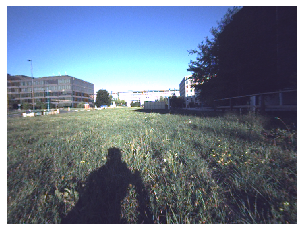

In [128]:
plt.imshow(player._shared_var["image_to_show"][:,:,::-1])
plt.axis('off')
output_path = f"/home/chenyu/Pictures/new_elevmap_capture_2/{name}.png"
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

In [88]:
# groundmapspath = "/Data/italy/extract_trajectories_007_Italy_onlyMap"\
#        "/extract_trajectories/Reconstruct_2022-07-18-20-34-01_0/localGroundMaps"
groundmapspath = f"/Data/italy/extract_trajectories_007_Italy_onlyMap"\
       f"/extract_trajectories/Reconstruct_2022-07-{datatrajname}_0/localGroundMaps"

def _cal_grounddict_distance_to_pos(p, pos):
    with open(p, "rb") as data_file:
        data = data_file.read()
        ground_dict = msgpack.unpackb(data)
    xmid = np.array(ground_dict['xRealRange']).mean()
    ymid = np.array(ground_dict['yRealRange']).mean()
    pos = pos[:2]
    return ((np.array([xmid,ymid]) - pos)**2).sum()

all_local_maps = list(glob(groundmapspath+"/*"))
target_local_map = np.array(list(map(lambda a:_cal_grounddict_distance_to_pos(a, player._shared_var["pose_buffer"][:2]), all_local_maps))).argmin()
evaluator = ElevationMapEvaluator(all_local_maps[target_local_map], elevation_pred.param, 1)

# evaluator = ElevationMapEvaluator(groundmappath, elevation_pred.param)



load ground dict, y real range:  [81.73713474437142, 98.52561482720304] x real range:  [-65.02428251184455, -40.12219253287348]


In [56]:
p = all_local_maps[target_local_map]
with open(p, "rb") as data_file:
    data = data_file.read()
    ground_dict = msgpack.unpackb(data)
ground_dict['timespan']

[1652350534.2739992, 1652350584.2764053]

In [57]:
player.bag.get_start_time()+start

1652350582.6850874

min and max -10.154432 -9.365229
error_pred RMSE 0.13953256305013678
error_pc RMSE 0.3179546185166392
error_smooth RMSE 0.27767963110662336
error_pred mean err 0.11798711459518481
error_pc mean err 0.2999867117752173
error_smooth mean err 0.2628089408719398
error_pred max 0.40436145685550073 7083
error_pc max 0.6950404614925336 5643
error_smooth max 0.5355489863291005 9618
0.40436145685550073


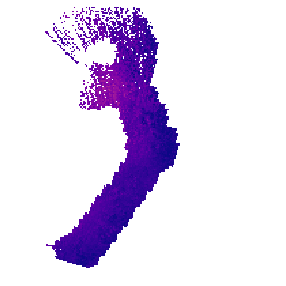

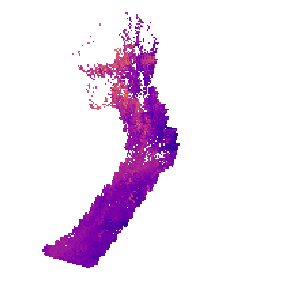

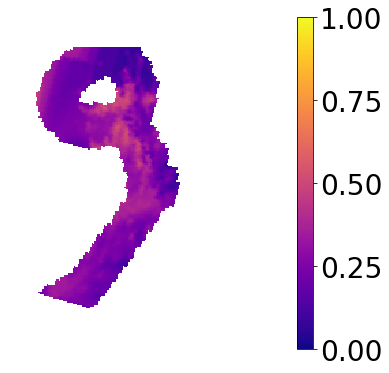

In [89]:
import matplotlib.pyplot as plt
## Execute this block to compute the error against ground truth height
v = player._shared_var
((elevmap_pred, smotmap_pred), (elevmap_pc, smotmap_pc)) = v["elevmap_buffer"]
print("min and max", elevmap_pred[~np.isnan(elevmap_pred)].min(), 
          elevmap_pred[~np.isnan(elevmap_pred)].max())
pose = v["pose_buffer"]
rz = Rotation.from_quat(pose[3:]).as_euler('xyz',degrees=False)[2]
error_pred = abs(evaluator.compute_error_against_gpmap(elevmap_pred, pose[:2], rz)[::-1,::-1])
# error_smpred = abs(evaluator.compute_error_against_gpmap(smotmap_pred, pose[:2], rz)[::-1,::-1])
error_smooth = abs(evaluator.compute_error_against_gpmap(smotmap_pc, pose[:2], rz)[::-1,::-1])
error_pc = abs(evaluator.compute_error_against_gpmap(elevmap_pc, pose[:2], rz)[::-1,::-1])
# error_pred[abs(error_pred)>0.1] = 0.1
# error_pc[abs(error_pc)>0.1] = 0.1
# error_smooth[abs(error_smooth)>0.1] = 0.1
print("error_pred RMSE", np.sqrt(np.sum(error_pred[~np.isnan(error_pred)]**2)/np.sum(~np.isnan(error_pred))))
print("error_pc RMSE", np.sqrt(np.sum(error_pc[~np.isnan(error_pc)]**2)/np.sum(~np.isnan(error_pc))))
print("error_smooth RMSE", np.sqrt(np.sum(error_smooth[~np.isnan(error_smooth)]**2)/np.sum(~np.isnan(error_smooth))))
# print("error_smpred RMSE", np.sqrt(np.sum(error_smpred[~np.isnan(error_smpred)]**2)/np.sum(~np.isnan(error_smpred))))

print("error_pred mean err", np.sum(abs(error_pred[~np.isnan(error_pred)]))/np.sum(~np.isnan(error_pred)))
print("error_pc mean err", np.sum(abs(error_pc[~np.isnan(error_pc)]))/np.sum(~np.isnan(error_pc)))
print("error_smooth mean err", np.sum(abs(error_smooth[~np.isnan(error_smooth)]))/np.sum(~np.isnan(error_smooth)))

print("error_pred max", np.max(abs(error_pred[~np.isnan(error_pred)])),np.sum(~np.isnan(error_pred)))
print("error_pc max", np.max(abs(error_pc[~np.isnan(error_pc)])),np.sum(~np.isnan(error_pc)))
print("error_smooth max", np.max(abs(error_smooth[~np.isnan(error_smooth)])),np.sum(~np.isnan(error_smooth)))


print(error_pred[~np.isnan(error_pred)].max())

def boundary(img):
#     img[:1,:] = 0
#     img[-1:,:] = 0
#     img[:,:1] = 0
#     img[:,-1:] = 0
    return img

vmax = 1
extent = (0, 1, 0, 1)
outname = f"/home/chenyu/Pictures/new_elevmap_capture_2/{datatrajname}_err_{int(start)}_"
plt.figure(figsize=(5,5))
plt.imshow(boundary(error_pred),cmap = "plasma",vmin=0, vmax=vmax, extent=extent)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

plt.savefig(outname + "pred.png", bbox_inches='tight', pad_inches=0)

plt.figure(figsize=(5,5))
plt.imshow(boundary(error_pc),cmap = "plasma",vmin=0, vmax=vmax, extent=extent)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.savefig(outname + "pc.png", bbox_inches='tight', pad_inches=0)

plt.figure(figsize=(6.1,6.1))
plt.imshow(boundary(error_smooth),cmap = "plasma",vmin=0, vmax=vmax, extent=extent)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ticks = np.linspace(0,vmax,5)
cb = plt.colorbar(ticks=list(ticks))
cb.ax.set_yticklabels([f'{x:.2f}' for x in ticks])
cb.ax.tick_params(labelsize=28)
plt.savefig(outname + "smooth.png", bbox_inches='tight', pad_inches=0)


# TMP


In [8]:
# Importing Image class from PIL module
from PIL import Image
from glob import glob
import os
source_dir = "/home/chenyu/Pictures/new_trajmap_capture/"
target_dir = "/home/chenyu/Pictures/new_trajmap_crop/"

# Opens a image in RGB mode

for f in glob(os.path.join(source_dir, "*.png")):
    if("err" in f): continue
    im = Image.open(f)
    # Cropped image of above dimension
    # (It will not change original image)
    imc = im.crop((18,180+32,1761,1964))
    imc.save(os.path.join(target_dir, os.path.basename(f)))


for f in glob(os.path.join(target_dir, "*.png")):
    im = Image.open(f)
    # Cropped image of above dimension
    # (It will not change original image)
    im1 = im.crop((607,3,1138,399))
#     im1 = im.crop((630,0,1112,363))
    im2 = im.crop((0,411,1743,1752))
#     im2 = im.crop((1,375,1743,1752))
    f1 = f[:-4] + "_rgb"+f[-4:]
    f2 = f[:-4] + "_viz"+f[-4:]
    if ("pred" in f1): im1.save(f1)
    im2.save(f2)
    

In [ ]:
# im = Image.open("/home/chenyu/Pictures/elevmap_capture/01_pred.png")
import os
# im.show()
# display(im.crop((18,180+32,1761,1964)))
f = "/home/chenyu/Pictures/elevmap_capture/01_pred.png"
os.path.basename(f)

## Headache

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

x = np.random.random(size=(10,10))


fig = plt.figure()
grid1 = ImageGrid(fig, 311,
                nrows_ncols = (1,3),
                axes_pad = 0.05,
                cbar_location = "right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.05
                )

grid1[0].imshow(x)
grid1[0].axis('off')
grid1[0].set_title('dog')

grid1[1].imshow(x, cmap='hot', interpolation='nearest')
grid1[1].axis('off')
grid1[1].set_title('dog')

imc = grid1[2].imshow(x, cmap='hot', interpolation='nearest')
grid1[2].axis('off')
grid1[2].set_title('dog')
plt.colorbar(imc, cax=grid1.cbar_axes[0])


x = x+10
grid2 = ImageGrid(fig, 312,
                nrows_ncols = (1,3),
                axes_pad = 0.05,
                cbar_location = "right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.05
                )

grid2[0].imshow(x)
grid2[0].axis('off')
grid2[0].set_title('dog')

grid2[1].imshow(x, cmap='hot', interpolation='nearest')
grid2[1].axis('off')
grid2[1].set_title('dog')

imc = grid2[2].imshow(x, cmap='hot', interpolation='nearest')
grid2[2].axis('off')
grid2[2].set_title('dog')
plt.colorbar(imc, cax=grid2.cbar_axes[0])



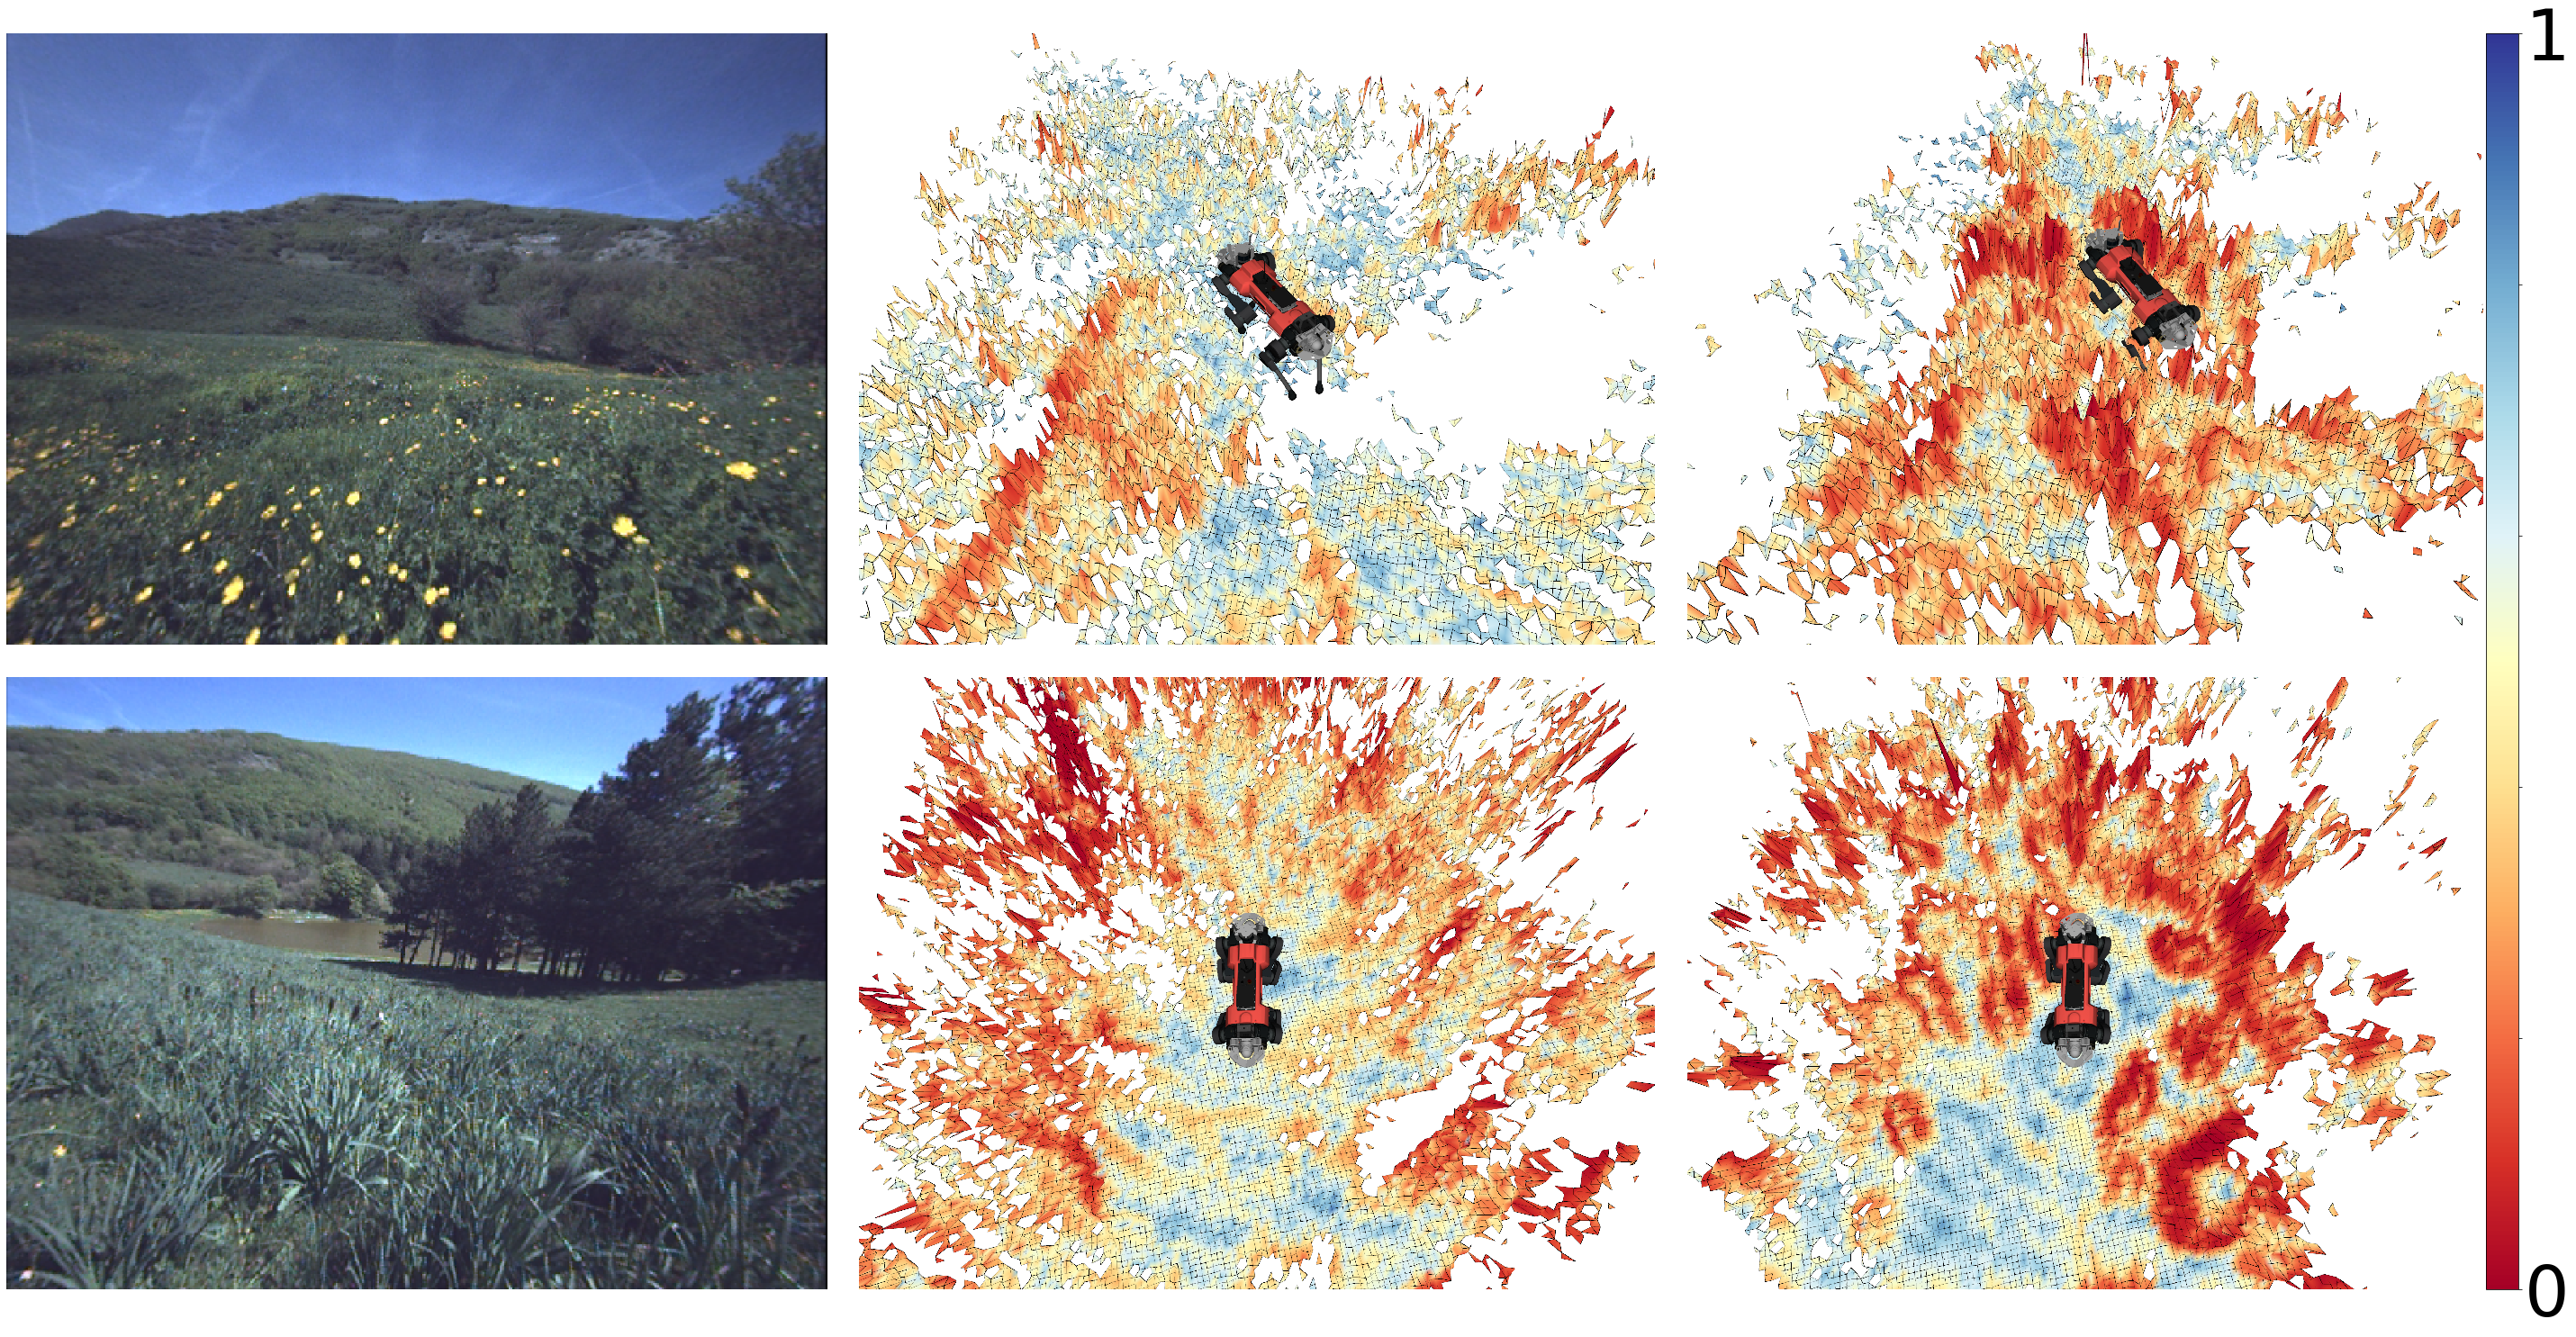

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
from matplotlib import cm
import cv2

prefix02 = "/home/chenyu/Pictures/new_trajmap_crop/03_{}_470"
rgb02 = cv2.imread(prefix02.format("pred") + "_rgb.png")[...,::-1]

pred02 = cv2.imread(prefix02.format("pred") + "_viz.png")[...,::-1]
raw02 = cv2.imread(prefix02.format("raw") + "_viz.png")[...,::-1]

scale_percent =  raw02.shape[0] / rgb02.shape[0]
dim = (int(rgb02.shape[1] * scale_percent), int(rgb02.shape[0] * scale_percent))
rgb_resize02 = cv2.resize(rgb02, dim, interpolation = cv2.INTER_AREA)


prefix06 = "/home/chenyu/Pictures/new_trajmap_crop/06_{}_33"
rgb06 = cv2.imread(prefix06.format("pred") + "_rgb.png")[...,::-1]

pred06 = cv2.imread(prefix06.format("pred") + "_viz.png")[...,::-1]
raw06 = cv2.imread(prefix06.format("raw") + "_viz.png")[...,::-1]

scale_percent =  raw06.shape[0] / rgb06.shape[0]
dim = (int(rgb06.shape[1] * scale_percent), int(rgb06.shape[0] * scale_percent))
rgb_resize06 = cv2.resize(rgb06, dim, interpolation = cv2.INTER_AREA)


from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(50,42))
grid = ImageGrid(fig, 111,
                nrows_ncols = (2,3),
#                 axes_pad = 0.05,
                axes_pad = 0.5,
                 cbar_location = "right",
                cbar_mode="single",
                cbar_size="2%",
                cbar_pad=0.05
                )

grid[0].imshow(rgb_resize02)
grid[0].axis('off')

grid[1].imshow(pred02)
grid[1].axis('off')

grid[2].imshow(raw02)
grid[2].axis('off')

grid[3].imshow(rgb_resize06)
grid[3].axis('off')

grid[4].imshow(pred06)
grid[4].axis('off')

grid[5].imshow(raw06)
grid[5].axis('off')

cbar = plt.colorbar(cm.ScalarMappable(cmap="RdYlBu"), cax=grid.cbar_axes[0])
cbar.ax.set_yticklabels(['0','','','','','1'], fontsize=78)
# cbar.set_label('Traversability', rotation=270, fontsize=78)

plt.savefig("/home/chenyu/Pictures/traversability_compare.png", bbox_inches='tight', pad_inches=0)

In [9]:
ori = cv2.imread("/home/chenyu/Pictures/traversability_compare.png")
scale_percent = 0.2
dim = (int(ori.shape[1] * scale_percent), int(ori.shape[0] * scale_percent))
resized = cv2.resize(ori, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite("/home/chenyu/Pictures/traversability_compare_resized.png", resized)

True

In [20]:

_path = "/Data/italy/extract_trajectories_007_Italy_onlyMap"\
"/extract_trajectories/Reconstruct_2022-07-18-20-34-01_0/localGroundMaps"
import msgpack
import msgpack_numpy as m
m.patch()

[-16.45184394803706, 3.711307624349044] [-3.295388865615678, 17.456245083723395]
[-17.689064568804767, -4.139181688961471] [-0.28035886403941257, 24.123181926815775]
[-17.689064568804767, -1.651169403824774] [13.018588437910164, 34.72845043915155]
[-15.905704178779843, -1.651169403824774] [19.91340632752161, 49.938537250324586]
[-25.05429306896862, -7.833949065045829] [30.159170845321988, 59.20779052810423]
[-38.86456498590825, -8.797199429435976] [45.733457585369955, 63.37312162578357]
[-46.13316807546287, -20.151344585629076] [54.44413929265082, 64.73404950386964]
[-57.716903549878765, -33.98320206957821] [58.802564887836766, 73.99016122709108]
[-73.92477827881764, -41.26804268206652] [59.947597593243046, 77.94099319661632]
[-89.04080494127341, -53.27073640098372] [69.76678795583918, 83.08467583008289]
[-103.87267554940631, -69.40339469519483] [72.99799459472615, 89.55719659713981]
[-108.38099452324194, -84.64753823721364] [78.8837977858832, 91.74212214457327]
[-108.38099452324194, -